# 07 - XGBoost All LLM Comparison (2K Sample)

**Purpose**: Compare XGBoost performance across 6 models to identify best LLM ground truth

## Models to Compare:

1. **Baseline**: XGBoost without OCEAN features (36 base features)
2. **Llama OCEAN**: Base features + Llama ground truth OCEAN (5 features)
3. **GPT OCEAN**: Base features + GPT ground truth OCEAN (5 features)
4. **Qwen OCEAN**: Base features + Qwen ground truth OCEAN (5 features)
5. **Gemma OCEAN**: Base features + Gemma ground truth OCEAN (5 features)
6. **DeepSeek OCEAN**: Base features + DeepSeek ground truth OCEAN (5 features)

## Evaluation Metrics:

- **Primary**: ROC-AUC
- **Secondary**: Precision, Recall, F1-Score
- **Analysis**: Feature importance, ROC curves, statistical tests

## Expected Outcomes:

- Identify which LLM ground truth produces best OCEAN features for loan default prediction
- Determine if OCEAN features improve prediction compared to baseline

**Estimated Time**: 15-20 minutes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

import xgboost as xgb
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve
)

from scipy import stats

# Set random seed
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)
plt.style.use('seaborn-v0_8-darkgrid')

print("Libraries loaded successfully")
print(f"Timestamp: {datetime.now()}")

Libraries loaded successfully
Timestamp: 2025-10-31 13:16:50.273832


## Step 1: Configuration

In [2]:
# Configuration
CONFIG = {
    # Input file (from 05g notebook)
    'input_data': '../loan_2k_with_all_ocean.csv',
    
    # Output files
    'output_comparison': '../07_xgboost_llm_comparison_2k.csv',
    'output_visualization': '../07_xgboost_llm_comparison_2k.png',
    'output_report': '../07_xgboost_llm_comparison_2k.json',
    
    # LLM models to compare
    'llm_models': ['llama', 'gpt', 'qwen', 'gemma', 'deepseek'],
    
    # OCEAN dimensions
    'ocean_dims': ['openness', 'conscientiousness', 'extraversion', 'agreeableness', 'neuroticism'],
    
    # Model parameters
    'xgboost_params': {
        'n_estimators': 100,
        'max_depth': 6,
        'learning_rate': 0.1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'random_state': RANDOM_STATE,
        'eval_metric': 'logloss',
        'early_stopping_rounds': 10
    },
    
    # Train/test split
    'test_size': 0.2,
    'random_state': RANDOM_STATE,
    
    # Features to remove
    'remove_features': ['emp_title', 'title', 'earliest_cr_line', 'desc']
}

print("Configuration:")
print(f"  Input data: {CONFIG['input_data']}")
print(f"  LLM models: {CONFIG['llm_models']}")
print(f"  OCEAN dimensions: {CONFIG['ocean_dims']}")
print(f"  Test size: {CONFIG['test_size']*100:.0f}%")
print(f"\nXGBoost parameters: {CONFIG['xgboost_params']}")

Configuration:
  Input data: ../loan_2k_with_all_ocean.csv
  LLM models: ['llama', 'gpt', 'qwen', 'gemma', 'deepseek']
  OCEAN dimensions: ['openness', 'conscientiousness', 'extraversion', 'agreeableness', 'neuroticism']
  Test size: 20%

XGBoost parameters: {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8, 'random_state': 42, 'eval_metric': 'logloss', 'early_stopping_rounds': 10}


## Step 2: Load Data

In [3]:
# Load data
print("Loading data...")
df = pd.read_csv(CONFIG['input_data'], low_memory=False)
print(f"  Rows: {len(df):,}")
print(f"  Columns: {len(df.columns)}")

# Check target column
if 'target' not in df.columns:
    raise ValueError("Missing target column!")

print(f"\nTarget distribution:")
print(df['target'].value_counts())
print(f"Default rate: {df['target'].mean()*100:.2f}%")

# Verify all OCEAN columns exist
print(f"\nVerifying OCEAN columns...")
for llm in CONFIG['llm_models']:
    ocean_cols = [f"{llm}_{dim}" for dim in CONFIG['ocean_dims']]
    missing = [col for col in ocean_cols if col not in df.columns]
    if missing:
        raise ValueError(f"Missing columns for {llm.upper()}: {missing}")
    print(f"  {llm.upper()}: {len(ocean_cols)} columns found")

print(f"\nData loaded successfully!")

Loading data...
  Rows: 2,000
  Columns: 63

Target distribution:
target
0    1707
1     293
Name: count, dtype: int64
Default rate: 14.65%

Verifying OCEAN columns...
  LLAMA: 5 columns found
  GPT: 5 columns found
  QWEN: 5 columns found
  GEMMA: 5 columns found
  DEEPSEEK: 5 columns found

Data loaded successfully!


## Step 3: Prepare Feature Sets

Create 6 feature sets:
- Baseline: Base features only (no OCEAN)
- Llama: Base features + llama_* OCEAN
- GPT: Base features + gpt_* OCEAN
- Qwen: Base features + qwen_* OCEAN
- Gemma: Base features + gemma_* OCEAN
- DeepSeek: Base features + deepseek_* OCEAN

In [4]:
# Separate features and target
y = df['target']
X_all = df.drop(columns=['target'], errors='ignore')

# Remove high cardinality features
X_all = X_all.drop(columns=CONFIG['remove_features'], errors='ignore')

print(f"Full feature set shape: {X_all.shape}")

# Identify all OCEAN columns
all_ocean_cols = []
for llm in CONFIG['llm_models']:
    for dim in CONFIG['ocean_dims']:
        all_ocean_cols.append(f"{llm}_{dim}")

print(f"Total OCEAN columns: {len(all_ocean_cols)}")

# 1. Baseline: Remove ALL OCEAN features
X_baseline = X_all.drop(columns=all_ocean_cols, errors='ignore')
print(f"\n1. Baseline features: {X_baseline.shape[1]} features")

# 2-6. Each LLM: Base + specific LLM OCEAN features
X_llm_sets = {}

for i, llm in enumerate(CONFIG['llm_models'], start=2):
    llm_ocean_cols = [f"{llm}_{dim}" for dim in CONFIG['ocean_dims']]
    X_llm = X_baseline.copy()
    
    # Add LLM-specific OCEAN features
    for col in llm_ocean_cols:
        X_llm[col] = X_all[col]
    
    X_llm_sets[llm] = X_llm
    print(f"{i}. {llm.upper()} OCEAN features: {X_llm.shape[1]} features ({len(llm_ocean_cols)} OCEAN added)")

print(f"\nFeature sets prepared!")

Full feature set shape: (2000, 58)
Total OCEAN columns: 25

1. Baseline features: 33 features
2. LLAMA OCEAN features: 38 features (5 OCEAN added)
3. GPT OCEAN features: 38 features (5 OCEAN added)
4. QWEN OCEAN features: 38 features (5 OCEAN added)
5. GEMMA OCEAN features: 38 features (5 OCEAN added)
6. DEEPSEEK OCEAN features: 38 features (5 OCEAN added)

Feature sets prepared!


## Step 4: Train/Test Split

Use consistent split across all models for fair comparison

In [5]:
# Single train/test split
print("Performing train/test split (80/20)...\n")

# Get train/test indices
indices = np.arange(len(y))
train_idx, test_idx = train_test_split(
    indices,
    test_size=CONFIG['test_size'],
    random_state=CONFIG['random_state'],
    stratify=y
)

# Split target
y_train = y.iloc[train_idx]
y_test = y.iloc[test_idx]

# Split baseline
X_baseline_train = X_baseline.iloc[train_idx]
X_baseline_test = X_baseline.iloc[test_idx]

# Split each LLM set
X_llm_train = {}
X_llm_test = {}

for llm, X_llm in X_llm_sets.items():
    X_llm_train[llm] = X_llm.iloc[train_idx]
    X_llm_test[llm] = X_llm.iloc[test_idx]

print(f"Training set: {len(y_train):,} samples ({len(y_train)/len(y)*100:.1f}%)")
print(f"Test set: {len(y_test):,} samples ({len(y_test)/len(y)*100:.1f}%)")

print(f"\nTrain default rate: {y_train.mean()*100:.2f}%")
print(f"Test default rate: {y_test.mean()*100:.2f}%")

print(f"\nTrain class distribution:")
print(y_train.value_counts())
print(f"\nTest class distribution:")
print(y_test.value_counts())

Performing train/test split (80/20)...

Training set: 1,600 samples (80.0%)
Test set: 400 samples (20.0%)

Train default rate: 14.62%
Test default rate: 14.75%

Train class distribution:
target
0    1366
1     234
Name: count, dtype: int64

Test class distribution:
target
0    341
1     59
Name: count, dtype: int64


## Step 5: Create Preprocessing Pipelines

In [6]:
def create_preprocessor(X):
    """
    Create preprocessing pipeline for given feature set.
    
    Args:
        X: Feature dataframe
    
    Returns:
        tuple: (preprocessor, numeric_features, categorical_features)
    """
    # Identify feature types
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = X.select_dtypes(include=['object']).columns.tolist()
    
    # Numeric preprocessing
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    # Categorical preprocessing
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    # Combined preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])
    
    return preprocessor, numeric_features, categorical_features


# Create preprocessors
print("Creating preprocessing pipelines...\n")

preprocessors = {}

# Baseline
preprocessor_baseline, num_feats, cat_feats = create_preprocessor(X_baseline_train)
preprocessors['baseline'] = preprocessor_baseline
print(f"Baseline preprocessor:")
print(f"  Numeric features: {len(num_feats)}")
print(f"  Categorical features: {len(cat_feats)}")

# Each LLM
for llm in CONFIG['llm_models']:
    preprocessor_llm, num_feats, cat_feats = create_preprocessor(X_llm_train[llm])
    preprocessors[llm] = preprocessor_llm
    print(f"\n{llm.upper()} preprocessor:")
    print(f"  Numeric features: {len(num_feats)}")
    print(f"  Categorical features: {len(cat_feats)}")

print(f"\nPreprocessing pipelines created!")

Creating preprocessing pipelines...

Baseline preprocessor:
  Numeric features: 21
  Categorical features: 12

LLAMA preprocessor:
  Numeric features: 26
  Categorical features: 12

GPT preprocessor:
  Numeric features: 26
  Categorical features: 12

QWEN preprocessor:
  Numeric features: 26
  Categorical features: 12

GEMMA preprocessor:
  Numeric features: 26
  Categorical features: 12

DEEPSEEK preprocessor:
  Numeric features: 26
  Categorical features: 12

Preprocessing pipelines created!


## Step 6: Preprocess Data

In [7]:
print("Preprocessing data...\n")

# Storage for processed data
X_processed = {}

# Baseline
print("Preprocessing Baseline...")
X_baseline_train_processed = preprocessors['baseline'].fit_transform(X_baseline_train)
X_baseline_test_processed = preprocessors['baseline'].transform(X_baseline_test)
X_processed['baseline'] = (X_baseline_train_processed, X_baseline_test_processed)
print(f"  Train shape: {X_baseline_train_processed.shape}")
print(f"  Test shape: {X_baseline_test_processed.shape}")

# Each LLM
for llm in CONFIG['llm_models']:
    print(f"\nPreprocessing {llm.upper()}...")
    X_train_processed = preprocessors[llm].fit_transform(X_llm_train[llm])
    X_test_processed = preprocessors[llm].transform(X_llm_test[llm])
    X_processed[llm] = (X_train_processed, X_test_processed)
    print(f"  Train shape: {X_train_processed.shape}")
    print(f"  Test shape: {X_test_processed.shape}")

print("\nData preprocessing complete!")

Preprocessing data...

Preprocessing Baseline...
  Train shape: (1600, 712)
  Test shape: (400, 712)

Preprocessing LLAMA...
  Train shape: (1600, 717)
  Test shape: (400, 717)

Preprocessing GPT...
  Train shape: (1600, 717)
  Test shape: (400, 717)

Preprocessing QWEN...
  Train shape: (1600, 717)
  Test shape: (400, 717)

Preprocessing GEMMA...
  Train shape: (1600, 717)
  Test shape: (400, 717)

Preprocessing DEEPSEEK...
  Train shape: (1600, 717)
  Test shape: (400, 717)

Data preprocessing complete!


## Step 7: Train XGBoost Models

In [8]:
# Calculate class weight
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Class weight (scale_pos_weight): {scale_pos_weight:.2f}\n")

# Update XGBoost parameters
xgb_params = CONFIG['xgboost_params'].copy()
xgb_params['scale_pos_weight'] = scale_pos_weight

# Storage for results
results = {}


def train_and_evaluate(name, X_train, X_test, y_train, y_test, params):
    """
    Train XGBoost model and evaluate performance.
    
    Returns:
        dict: Model, predictions, and metrics
    """
    print(f"Training {name}...")
    
    # Create model
    model = xgb.XGBClassifier(**params)
    
    # Train
    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=False
    )
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_pred_proba)
    cm = confusion_matrix(y_test, y_pred)
    
    print(f"  AUC: {auc:.4f}")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1: {f1:.4f}")
    
    return {
        'model': model,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'metrics': {
            'accuracy': float(accuracy),
            'precision': float(precision),
            'recall': float(recall),
            'f1': float(f1),
            'auc': float(auc)
        },
        'confusion_matrix': cm.tolist(),
        'name': name
    }


print("="*80)
print("Training XGBoost Models")
print("="*80 + "\n")

# Train Baseline
X_train_proc, X_test_proc = X_processed['baseline']
results['baseline'] = train_and_evaluate(
    'Baseline (No OCEAN)',
    X_train_proc, X_test_proc,
    y_train, y_test,
    xgb_params
)

# Train each LLM model
for llm in CONFIG['llm_models']:
    print()
    X_train_proc, X_test_proc = X_processed[llm]
    results[llm] = train_and_evaluate(
        f'{llm.upper()} OCEAN',
        X_train_proc, X_test_proc,
        y_train, y_test,
        xgb_params
    )

print("\n" + "="*80)
print("Model Training Complete")
print("="*80)

Class weight (scale_pos_weight): 5.84

Training XGBoost Models

Training Baseline (No OCEAN)...
  AUC: 0.5700
  Accuracy: 0.8050
  Precision: 0.2889
  Recall: 0.2203
  F1: 0.2500

Training LLAMA OCEAN...
  AUC: 0.5744
  Accuracy: 0.7975
  Precision: 0.2708
  Recall: 0.2203
  F1: 0.2430

Training GPT OCEAN...
  AUC: 0.6044
  Accuracy: 0.7975
  Precision: 0.2500
  Recall: 0.1864
  F1: 0.2136

Training QWEN OCEAN...
  AUC: 0.6078
  Accuracy: 0.7750
  Precision: 0.2373
  Recall: 0.2373
  F1: 0.2373

Training GEMMA OCEAN...
  AUC: 0.5959
  Accuracy: 0.8000
  Precision: 0.2766
  Recall: 0.2203
  F1: 0.2453

Training DEEPSEEK OCEAN...
  AUC: 0.6078
  Accuracy: 0.7750
  Precision: 0.2373
  Recall: 0.2373
  F1: 0.2373

Model Training Complete


## Step 8: Performance Comparison

In [9]:
# Create comparison dataframe
print("\n" + "="*80)
print("Performance Comparison")
print("="*80 + "\n")

comparison_data = []

for model_key, result in results.items():
    row = {
        'Model': result['name'],
        'AUC': result['metrics']['auc'],
        'Accuracy': result['metrics']['accuracy'],
        'Precision': result['metrics']['precision'],
        'Recall': result['metrics']['recall'],
        'F1': result['metrics']['f1']
    }
    comparison_data.append(row)

df_comparison = pd.DataFrame(comparison_data)

# Calculate improvement vs baseline
baseline_auc = results['baseline']['metrics']['auc']
df_comparison['AUC_vs_Baseline'] = df_comparison['AUC'] - baseline_auc
df_comparison['AUC_Improvement_%'] = (df_comparison['AUC_vs_Baseline'] / baseline_auc * 100)

# Sort by AUC descending
df_comparison = df_comparison.sort_values('AUC', ascending=False).reset_index(drop=True)

print(df_comparison.to_string(index=False))

# Save comparison
df_comparison.to_csv(CONFIG['output_comparison'], index=False)
print(f"\nComparison saved to: {CONFIG['output_comparison']}")


Performance Comparison

              Model    AUC  Accuracy  Precision  Recall     F1  AUC_vs_Baseline  AUC_Improvement_%
         QWEN OCEAN 0.6078    0.7750     0.2373  0.2373 0.2373           0.0378             6.6359
     DEEPSEEK OCEAN 0.6078    0.7750     0.2373  0.2373 0.2373           0.0378             6.6359
          GPT OCEAN 0.6044    0.7975     0.2500  0.1864 0.2136           0.0344             6.0342
        GEMMA OCEAN 0.5959    0.8000     0.2766  0.2203 0.2453           0.0258             4.5344
        LLAMA OCEAN 0.5744    0.7975     0.2708  0.2203 0.2430           0.0044             0.7674
Baseline (No OCEAN) 0.5700    0.8050     0.2889  0.2203 0.2500           0.0000             0.0000

Comparison saved to: ../07_xgboost_llm_comparison_2k.csv


## Step 9: Statistical Analysis

In [10]:
print("\n" + "="*80)
print("Statistical Analysis")
print("="*80 + "\n")

# Identify best LLM model
best_llm = df_comparison[df_comparison['Model'] != 'Baseline (No OCEAN)'].iloc[0]['Model'].split()[0].lower()
best_auc = results[best_llm]['metrics']['auc']

print(f"Best LLM Model: {best_llm.upper()}")
print(f"  AUC: {best_auc:.4f}")
print(f"  Improvement vs Baseline: {(best_auc - baseline_auc):.4f} ({(best_auc - baseline_auc)/baseline_auc*100:.2f}%)")

# Paired t-test for prediction probabilities
print(f"\nPaired t-test: Best LLM ({best_llm.upper()}) vs Baseline")
baseline_proba = results['baseline']['y_pred_proba']
best_proba = results[best_llm]['y_pred_proba']

t_stat, p_value = stats.ttest_rel(best_proba, baseline_proba)
print(f"  t-statistic: {t_stat:.4f}")
print(f"  p-value: {p_value:.4f}")

if p_value < 0.05:
    print(f"  Result: Statistically significant difference (p < 0.05)")
else:
    print(f"  Result: No statistically significant difference (p >= 0.05)")

# Compare all LLMs
print(f"\nPairwise AUC differences vs Baseline:")
for llm in CONFIG['llm_models']:
    llm_auc = results[llm]['metrics']['auc']
    diff = llm_auc - baseline_auc
    pct = diff / baseline_auc * 100
    print(f"  {llm.upper()}: {diff:+.4f} ({pct:+.2f}%)")


Statistical Analysis

Best LLM Model: QWEN
  AUC: 0.6078
  Improvement vs Baseline: 0.0378 (6.64%)

Paired t-test: Best LLM (QWEN) vs Baseline
  t-statistic: 6.8106
  p-value: 0.0000
  Result: Statistically significant difference (p < 0.05)

Pairwise AUC differences vs Baseline:
  LLAMA: +0.0044 (+0.77%)
  GPT: +0.0344 (+6.03%)
  QWEN: +0.0378 (+6.64%)
  GEMMA: +0.0258 (+4.53%)
  DEEPSEEK: +0.0378 (+6.64%)


## Step 10: Visualizations


Visualization saved to: ../07_xgboost_llm_comparison_2k.png


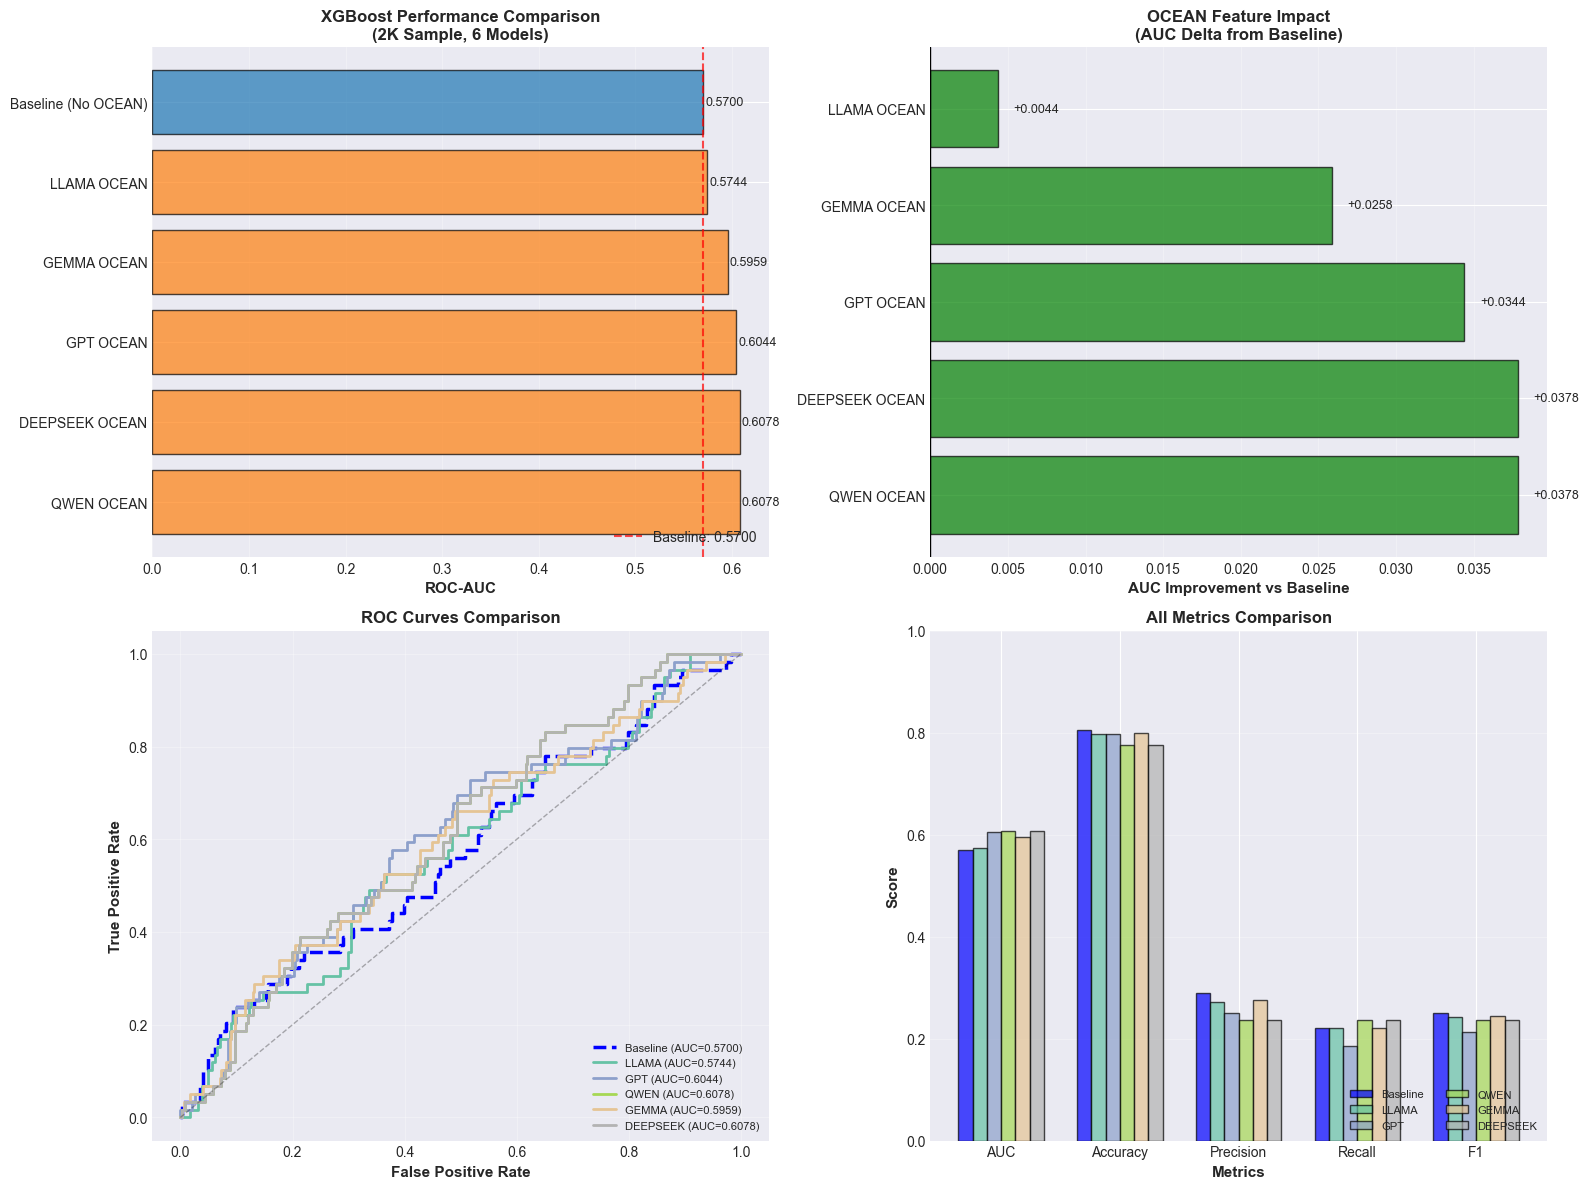

In [11]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. AUC Bar Chart
ax1 = axes[0, 0]
models = df_comparison['Model'].tolist()
aucs = df_comparison['AUC'].tolist()
colors = ['#1f77b4' if 'Baseline' in m else '#ff7f0e' for m in models]

bars = ax1.barh(range(len(models)), aucs, color=colors, alpha=0.7, edgecolor='black')
ax1.set_yticks(range(len(models)))
ax1.set_yticklabels(models)
ax1.set_xlabel('ROC-AUC', fontsize=11, fontweight='bold')
ax1.set_title('XGBoost Performance Comparison\n(2K Sample, 6 Models)', 
              fontsize=12, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Add value labels
for i, (bar, auc) in enumerate(zip(bars, aucs)):
    ax1.text(auc + 0.002, bar.get_y() + bar.get_height()/2, 
             f'{auc:.4f}', va='center', fontsize=9)

# Add baseline reference line
ax1.axvline(baseline_auc, color='red', linestyle='--', linewidth=1.5, 
            label=f'Baseline: {baseline_auc:.4f}', alpha=0.7)
ax1.legend(loc='lower right')


# 2. AUC Improvement Bar Chart
ax2 = axes[0, 1]
llm_rows = df_comparison[df_comparison['Model'] != 'Baseline (No OCEAN)']
llm_models = llm_rows['Model'].tolist()
improvements = llm_rows['AUC_vs_Baseline'].tolist()
colors_imp = ['green' if x > 0 else 'red' for x in improvements]

bars2 = ax2.barh(range(len(llm_models)), improvements, color=colors_imp, alpha=0.7, edgecolor='black')
ax2.set_yticks(range(len(llm_models)))
ax2.set_yticklabels(llm_models)
ax2.set_xlabel('AUC Improvement vs Baseline', fontsize=11, fontweight='bold')
ax2.set_title('OCEAN Feature Impact\n(AUC Delta from Baseline)', 
              fontsize=12, fontweight='bold')
ax2.axvline(0, color='black', linestyle='-', linewidth=1)
ax2.grid(axis='x', alpha=0.3)

# Add value labels
for bar, imp in zip(bars2, improvements):
    x_pos = imp + 0.001 if imp > 0 else imp - 0.001
    ha = 'left' if imp > 0 else 'right'
    ax2.text(x_pos, bar.get_y() + bar.get_height()/2, 
             f'{imp:+.4f}', va='center', ha=ha, fontsize=9)


# 3. ROC Curves
ax3 = axes[1, 0]

# Baseline ROC
fpr_base, tpr_base, _ = roc_curve(y_test, results['baseline']['y_pred_proba'])
ax3.plot(fpr_base, tpr_base, label=f"Baseline (AUC={baseline_auc:.4f})", 
         linewidth=2.5, linestyle='--', color='blue')

# Each LLM ROC
colors_roc = plt.cm.Set2(np.linspace(0, 1, len(CONFIG['llm_models'])))
for llm, color in zip(CONFIG['llm_models'], colors_roc):
    fpr, tpr, _ = roc_curve(y_test, results[llm]['y_pred_proba'])
    auc_val = results[llm]['metrics']['auc']
    ax3.plot(fpr, tpr, label=f"{llm.upper()} (AUC={auc_val:.4f})", 
             linewidth=2, color=color)

# Diagonal reference
ax3.plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.3)

ax3.set_xlabel('False Positive Rate', fontsize=11, fontweight='bold')
ax3.set_ylabel('True Positive Rate', fontsize=11, fontweight='bold')
ax3.set_title('ROC Curves Comparison', fontsize=12, fontweight='bold')
ax3.legend(loc='lower right', fontsize=8)
ax3.grid(alpha=0.3)


# 4. All Metrics Comparison
ax4 = axes[1, 1]

metrics = ['AUC', 'Accuracy', 'Precision', 'Recall', 'F1']
x_pos = np.arange(len(metrics))
width = 0.12

# Plot baseline
baseline_vals = [results['baseline']['metrics'][m.lower()] for m in metrics]
ax4.bar(x_pos - 2.5*width, baseline_vals, width, label='Baseline', 
        color='blue', alpha=0.7, edgecolor='black')

# Plot each LLM
for i, (llm, color) in enumerate(zip(CONFIG['llm_models'], colors_roc)):
    llm_vals = [results[llm]['metrics'][m.lower()] for m in metrics]
    offset = (i - 2) * width + 0.5 * width
    ax4.bar(x_pos + offset, llm_vals, width, label=llm.upper(), 
            color=color, alpha=0.7, edgecolor='black')

ax4.set_xlabel('Metrics', fontsize=11, fontweight='bold')
ax4.set_ylabel('Score', fontsize=11, fontweight='bold')
ax4.set_title('All Metrics Comparison', fontsize=12, fontweight='bold')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(metrics)
ax4.legend(loc='lower right', fontsize=8, ncol=2)
ax4.grid(axis='y', alpha=0.3)
ax4.set_ylim(0, 1)

plt.tight_layout()
plt.savefig(CONFIG['output_visualization'], dpi=300, bbox_inches='tight')
print(f"\nVisualization saved to: {CONFIG['output_visualization']}")
plt.show()

## Step 11: Final Report

In [12]:
# Generate final report
report = {
    'experiment': '07_xgboost_all_llm_comparison_2k',
    'timestamp': datetime.now().isoformat(),
    'dataset': {
        'total_samples': int(len(df)),
        'train_samples': int(len(y_train)),
        'test_samples': int(len(y_test)),
        'default_rate': float(y.mean())
    },
    'models': {},
    'best_model': {
        'name': best_llm.upper(),
        'auc': float(best_auc),
        'improvement_vs_baseline': float(best_auc - baseline_auc),
        'improvement_percent': float((best_auc - baseline_auc) / baseline_auc * 100)
    },
    'statistical_test': {
        't_statistic': float(t_stat),
        'p_value': float(p_value),
        'significant': bool(p_value < 0.05)  # Convert NumPy bool to Python bool
    },
    'comparison_table': df_comparison.to_dict(orient='records')
}

# Add individual model results
for model_key, result in results.items():
    report['models'][model_key] = {
        'name': result['name'],
        'metrics': result['metrics'],
        'confusion_matrix': result['confusion_matrix']
    }

# Save report
with open(CONFIG['output_report'], 'w') as f:
    json.dump(report, f, indent=2)

print("\n" + "="*80)
print("FINAL SUMMARY")
print("="*80)
print(f"\nBest Performing Model: {best_llm.upper()} OCEAN")
print(f"  AUC: {best_auc:.4f}")
print(f"  Baseline AUC: {baseline_auc:.4f}")
print(f"  Improvement: {(best_auc - baseline_auc):.4f} ({(best_auc - baseline_auc)/baseline_auc*100:.2f}%)")
print(f"\nStatistical Significance: {'Yes' if p_value < 0.05 else 'No'} (p={p_value:.4f})")

print(f"\nRanking by AUC:")
for i, row in df_comparison.iterrows():
    print(f"  {i+1}. {row['Model']}: {row['AUC']:.4f}")

print(f"\nReport saved to: {CONFIG['output_report']}")
print(f"\nAnalysis complete!")


FINAL SUMMARY

Best Performing Model: QWEN OCEAN
  AUC: 0.6078
  Baseline AUC: 0.5700
  Improvement: 0.0378 (6.64%)

Statistical Significance: Yes (p=0.0000)

Ranking by AUC:
  1. QWEN OCEAN: 0.6078
  2. DEEPSEEK OCEAN: 0.6078
  3. GPT OCEAN: 0.6044
  4. GEMMA OCEAN: 0.5959
  5. LLAMA OCEAN: 0.5744
  6. Baseline (No OCEAN): 0.5700

Report saved to: ../07_xgboost_llm_comparison_2k.json

Analysis complete!
